# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

### The flea beetle problem

Different species of flea beetle can be distinguished by the width and angle of the aedeagus. The data below includes measurements and know species classification for 74 specimens.

Suppose you discover a new specimen under conditions where it is equally likely to be any of the three species. You measure the aedeagus and width 140 microns and angle 15 (in multiples of 7.5 degrees). What is the probability that it belongs to each species?

This problem is based on [this data story on DASL](https://web.archive.org/web/20160304083805/http://lib.stat.cmu.edu/DASL/Datafiles/FleaBeetles.html)

Datafile Name: Flea Beetles

Datafile Subjects: Biology

Story Names: Flea Beetles

Reference: Lubischew, A.A. (1962) On the use of discriminant functions in taxonomy. Biometrics, 18, 455-477. Also found in: Hand, D.J., et al. (1994) A Handbook of Small Data Sets, London: Chapman & Hall, 254-255.

Authorization: Contact Authors

Description: Data were collected on the genus of flea beetle Chaetocnema, which contains three species: concinna (Con), heikertingeri (Hei), and heptapotamica (Hep). Measurements were made on the width and angle of the aedeagus of each beetle. The goal of the original study was to form a classification rule to distinguish the three species.

Number of cases: 74

Variable Names:

Width: The maximal width of aedeagus in the forpart (in microns)

Angle: The front angle of the aedeagus (1 unit = 7.5 degrees)

Species: Species of flea beetle from the genus Chaetocnema


To solve this problem we have to account for two sources of uncertainty: given the data, we have some uncertainty about the actual distribution of attributes.  Then, given the measurements, we have uncertainty about which species we have.

First I'll load the data.

In [2]:
measurements = (140, 15)

(140, 15)

In [3]:
import pandas as pd

df = pd.read_csv('../data/flea_beetles.csv', delimiter='\t')
df.head()

,Width,Angle,Species
0,150,15,Con
1,147,13,Con
2,144,14,Con
3,144,16,Con
4,153,13,Con


In [4]:
def plot_cdfs(df, col):
    for name, group in df.groupby('Species'):
        cdf = Cdf(group[col], label=name)
        thinkplot.Cdf(cdf)
    
    thinkplot.Config(xlabel=col, legend=True, loc='lower right')

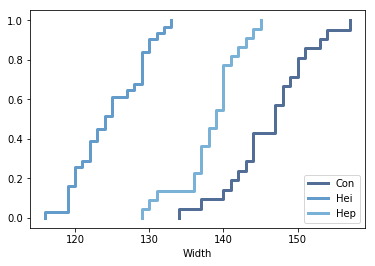

In [5]:
plot_cdfs(df, 'Width')

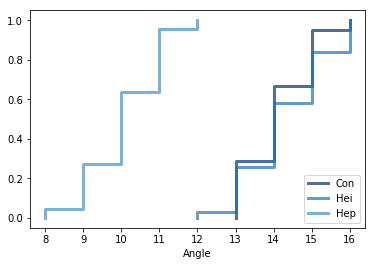

In [6]:
plot_cdfs(df, 'Angle')

The following class estimates the mean and standard deviation of a normal distribution, given the data:

In [7]:
from scipy.stats import norm
from thinkbayes2 import EvalNormalPdf

class Beetle(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        data: sequence of measurements
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = EvalNormalPdf(data, mu, sigma)
        return np.prod(likes)
    
    def PredictiveProb(self, data):
        """Compute the posterior total probability of a datum.
        
        data: sequence of measurements
        """
        total = 0
        for (mu, sigma), prob in self.Items():
            likes = norm.pdf(data, mu, sigma)
            total += prob * np.prod(likes)
        return total

Now we can estimate parameters for the widths, for each of the three species.

In [8]:
from itertools import product

def MakeWidthSuite(data):
    mus = np.linspace(115, 160, 51)
    sigmas = np.linspace(1, 10, 51)
    suite = Beetle(product(mus, sigmas))
    suite.Update(data)
    return suite

In [9]:
groups = df.groupby('Species')

Here are the posterior distributions for mu and sigma, and the predictive probability of the width measurement, for each species.

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Con 0.03801974738109857
Hei 0.0008566504685267518
Hep 0.08356251828048568


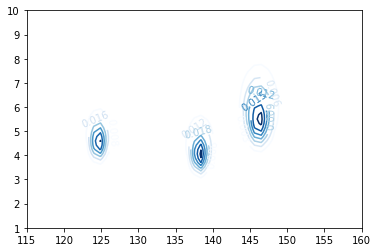

In [10]:
for name, group in groups:
    suite = MakeWidthSuite(group.Width)
    thinkplot.Contour(suite)
    print(name, suite.PredictiveProb(140))

Now we can do the same thing for the angles.

In [11]:
def MakeAngleSuite(data):
    mus = np.linspace(8, 16, 101)
    sigmas = np.linspace(0.1, 2, 101)
    suite = Beetle(product(mus, sigmas))
    suite.Update(data)
    return suite

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Con 0.26032388557956415
Hei 0.2846109227983482
Hep 0.00011381214875336172


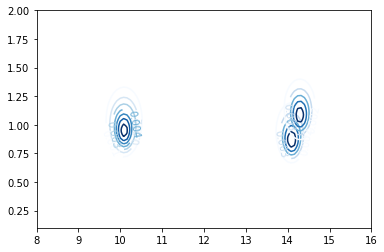

In [12]:
for name, group in groups:
    suite = MakeAngleSuite(group.Angle)
    thinkplot.Contour(suite)
    print(name, suite.PredictiveProb(15))

These posterior distributions are used to compute the likelihoods of the measurements.

In [13]:
class Species:
    
    def __init__(self, name, suite_width, suite_angle):
        self.name = name
        self.suite_width = suite_width
        self.suite_angle = suite_angle
        
    def __str__(self):
        return self.name
        
    def Likelihood(self, data):
        width, angle = data
        like1 = self.suite_width.PredictiveProb(width)
        like2 = self.suite_angle.PredictiveProb(angle)
        return like1 * like2

In [14]:
species = {}

for name, group in groups:
    suite_width = MakeWidthSuite(group.Width)
    suite_angle = MakeAngleSuite(group.Angle)
    species[name] = Species(name, suite_width, suite_angle)

For example, here's the likelihood of the data given that the species is 'Con'

In [15]:
species['Con'].Likelihood(measurements)

0.009897448367001037

Now we can make a `Classifier` that uses the `Species` objects as hypotheses.

In [16]:
class Classifier(Suite):
    
    def Likelihood(self, data, hypo):
        return hypo.Likelihood(data)

In [17]:
suite = Classifier(species.values())
for hypo, prob in suite.Items():
    print(hypo, prob)

Con 0.3333333333333333
Hei 0.3333333333333333
Hep 0.3333333333333333


In [32]:
suite.Update(measurements)
for hypo, prob in suite.Items():
    print(hypo, prob)

Con 0.9993926201318976
Hei 0.0006064571056100863
Hep 9.227624923935692e-07


## Now with MCMC

Based on [this example](https://docs.pymc.io/notebooks/LKJ.html)

In [33]:
from warnings import simplefilter
simplefilter('ignore', FutureWarning)

import pymc3 as pm

In [34]:
N = 10000

μ_actual = np.array([1, -2])
Σ_actual = np.array([[0.5, -0.3],
                     [-0.3, 1.]])

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

array([[ 1.47765532, -1.5487712 ],
       [ 0.85257664, -1.64336135],
       [ 0.01352011, -1.18703034],
       ...,
       [ 1.80448581, -2.80254805],
       [ 1.24246144, -2.40646863],
       [ 0.99976259, -2.43004282]])

In [35]:
df['Width10'] = df.Width / 10

observed = {}
for name, group in df.groupby('Species'):
    observed[name] = group[['Width10', 'Angle']].values
    print(name)
    print(np.cov(np.transpose(observed[name])))

Con
[[ 0.31661905 -0.09690476]
 [-0.09690476  0.79047619]]
Hei
[[ 0.21369892 -0.03268817]
 [-0.03268817  1.21290323]]
Hep
[[ 0.17160173 -0.05021645]
 [-0.05021645  0.94372294]]


In [36]:
x = observed['Con']

array([[15. , 15. ],
       [14.7, 13. ],
       [14.4, 14. ],
       [14.4, 16. ],
       [15.3, 13. ],
       [14. , 15. ],
       [15.1, 14. ],
       [14.3, 14. ],
       [14.4, 14. ],
       [14.2, 15. ],
       [14.1, 13. ],
       [15. , 15. ],
       [14.8, 13. ],
       [15.4, 15. ],
       [14.7, 14. ],
       [13.7, 14. ],
       [13.4, 15. ],
       [15.7, 14. ],
       [14.9, 13. ],
       [14.7, 13. ],
       [14.8, 14. ]])

In [37]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2, sd_dist=pm.HalfCauchy.dist(2.5))

In [27]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

In [28]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2,
                  testval=x.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=x)

In [29]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, packed_L]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 460.63draws/s]


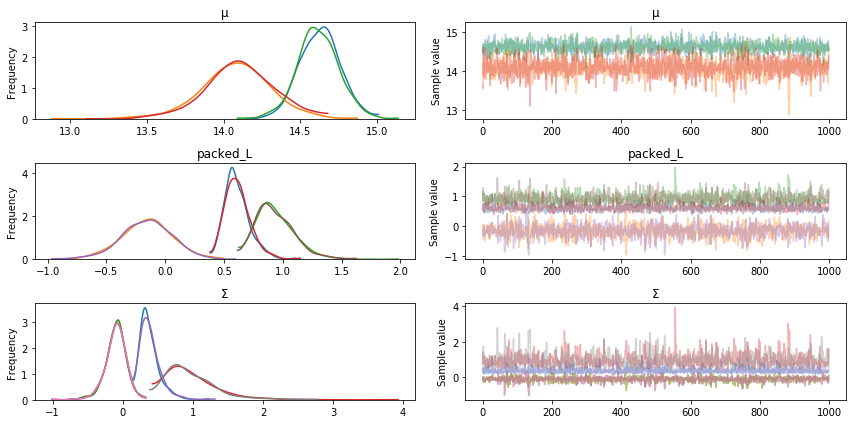

In [30]:
pm.traceplot(trace);

In [38]:
μ_post = trace['μ'].mean(axis=0)

array([14.61930629, 14.08705392])

In [39]:
Σ_post = trace['Σ'].mean(axis=0)

array([[ 0.38897242, -0.10173426],
       [-0.10173426,  0.97627525]])

In [40]:
from statsmodels.stats.moment_helpers import cov2corr

from scipy.stats import multivariate_normal

In [41]:
cov2corr(Σ_post)

array([[ 1.        , -0.16509036],
       [-0.16509036,  1.        ]])

In [42]:
measured = (14, 15)

total = 0
for row in trace:
    total += multivariate_normal.pdf(measured, mean=row['μ'], cov=row['Σ'])
    
total / len(trace)

0.11689017809121484

In [43]:
def compute_posterior_likelihood(measured, species):
    x = observed[species]
    
    with pm.Model() as model:
        packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2, sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(2, packed_L)
        Σ = pm.Deterministic('Σ', L.dot(L.T))
        μ = pm.Normal('μ', 0., 10., shape=2,
                      testval=x.mean(axis=0))
        obs = pm.MvNormal('obs', μ, chol=L, observed=x)
        trace = pm.sample(1000)
        
    total = 0
    for row in trace:
        total += multivariate_normal.pdf(measured, mean=row['μ'], cov=row['Σ'])
    
    return total / len(trace)

In [52]:
suite = Suite(['Con', 'Hep', 'Hei'])

Suite({'Con': 0.3333333333333333, 'Hep': 0.3333333333333333, 'Hei': 0.3333333333333333})

In [53]:
for hypo in suite:
    like = compute_posterior_likelihood(measured, hypo)
    print(hypo, like)
    suite[hypo] *= like

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, packed_L]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 485.47draws/s]


Con 0.11691725793654385


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, packed_L]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 415.57draws/s]


Hep 8.154600945681399e-05


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, packed_L]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 373.08draws/s]


Hei 0.0022412372165194943


In [54]:
suite.Normalize()

0.03974668038750672

In [55]:
suite.Print()

Con 0.9805201071441225
Hei 0.01879601176474573
Hep 0.0006838810911317073
